
# NHTS 2022 — Household VMT Modeling

This notebook ingests **all provided NextGen NHTS 2022 public-use tables**:

- `hhv2pub.csv` (Household)
- `perv2pub.csv` (Person)
- `tripv2pub.csv` (Trip)
- `vehv2pub.csv` (Vehicle)
- `ldtv2pub.csv` (Long-distance travel)

It constructs **household-level VMT**, performs **EDA**, engineers features by **aggregating from person, trip, vehicle, and LDT** tables, and trains/evaluates multiple models (Linear, Random Forest, XGBoost). It outputs metrics, interpretability artifacts, and CSVs for frontend use.


In [1]:
# ==========================================
# 0) Auto‐install Missing Packages (Cell 0)
# ==========================================
import importlib.util
import sys

# List of essential packages for this notebook
REQUIRED_PKGS = ["pandas", "numpy", "matplotlib", "scikit-learn", "xgboost", "shap"]

# Detect missing packages
missing = [pkg for pkg in REQUIRED_PKGS if importlib.util.find_spec(pkg) is None]

if missing:
    print("Installing missing packages:", missing)
    try:
        # In Jupyter: use magic
        get_ipython().run_line_magic('pip', f'install {" ".join(missing)}')
    except NameError:
        # Fallback for script execution
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
    print("Installation complete. Please restart the kernel before running subsequent cells.")
else:
    print("All required packages are already installed.")

Installing missing packages: ['scikit-learn']
Note: you may need to restart the kernel to use updated packages.
Installation complete. Please restart the kernel before running subsequent cells.


In [2]:

# ==========================================
# 1) Imports & Paths (PATH-SAFE + runtime module detection)
# ==========================================
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, importlib.util
import xgboost
import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Runtime detection of optional libraries (doesn't throw)
XGB_AVAILABLE  = importlib.util.find_spec("xgboost") is not None
SHAP_AVAILABLE = importlib.util.find_spec("shap") is not None
print(f"XGBoost available: {XGB_AVAILABLE}")
print(f"SHAP available:    {SHAP_AVAILABLE}")
print(f"Python exe:        {sys.executable}")

OUT_DIR = Path("./outputs_full")
FIG_DIR = OUT_DIR / "figs"
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

REQUIRED_FILES = ["hhv2pub.csv","perv2pub.csv","tripv2pub.csv","vehv2pub.csv","ldtv2pub.csv"]
DATA_CANDIDATES = [
    Path("."),
    Path("./data"),
    Path("../data"),
    Path("/mnt/data"),
    Path.home() / "Downloads",
]

def locate_file(filename):
    for d in DATA_CANDIDATES:
        p = d / filename
        if p.exists():
            return p
    for p in Path(".").glob(f"**/{filename}"):
        return p
    return None

DATA_PATHS = {fn: locate_file(fn) for fn in REQUIRED_FILES}
missing = [fn for fn, p in DATA_PATHS.items() if p is None]
print("Detected data paths:")
for k, v in DATA_PATHS.items():
    print(f"  {k}: {v if v is not None else 'NOT FOUND'}")

if missing:
    raise FileNotFoundError(
        "Could not find: " + ", ".join(missing)
        + "\\nPlace them next to this notebook or in one of: "
        + ", ".join(str(p) for p in DATA_CANDIDATES)
    )

def read_csv_safe(p: Path) -> pd.DataFrame:
    df = pd.read_csv(p)
    print(f"Loaded {p.name} from {p.parent}: {df.shape[0]:,} rows, {df.shape[1]:,} cols")
    return df


XGBoost available: True
SHAP available:    True
Python exe:        /Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9
Detected data paths:
  hhv2pub.csv: hhv2pub.csv
  perv2pub.csv: perv2pub.csv
  tripv2pub.csv: tripv2pub.csv
  vehv2pub.csv: vehv2pub.csv
  ldtv2pub.csv: ldtv2pub.csv


In [3]:

# ==========================================
# 2) Load Data (ALL tables)
# ==========================================
hh   = read_csv_safe(DATA_PATHS["hhv2pub.csv"])
per  = read_csv_safe(DATA_PATHS["perv2pub.csv"])
trip = read_csv_safe(DATA_PATHS["tripv2pub.csv"])
veh  = read_csv_safe(DATA_PATHS["vehv2pub.csv"])
ldt  = read_csv_safe(DATA_PATHS["ldtv2pub.csv"])


Loaded hhv2pub.csv from .: 7,893 rows, 43 cols
Loaded perv2pub.csv from .: 16,997 rows, 153 cols
Loaded tripv2pub.csv from .: 31,074 rows, 102 cols
Loaded vehv2pub.csv from .: 14,684 rows, 55 cols
Loaded ldtv2pub.csv from .: 16,997 rows, 74 cols


In [4]:

# ==========================================
# 3) Build Household VMT from TRIP; NUMVEH from VEH
# ==========================================
trip["TRPMILES"] = pd.to_numeric(trip.get("TRPMILES"), errors="coerce")
trip.loc[trip["TRPMILES"] < 0, "TRPMILES"] = np.nan

# HH-level aggregates from trip table
trip_agg = trip.groupby("HOUSEID").agg(
    HH_VMT=("TRPMILES", "sum"),                # total household miles
    N_TRIPS=("TRPMILES", "size"),              # count of trips
    MEAN_TRPMILES=("TRPMILES", "mean")
).reset_index()

# Optional mode/flags if present
for col in ["TDWKND","PUBTRANS","DRVR_FLG","PSGR_FLG","WALK","BIKE"]:
    if col in trip.columns:
        trip[col] = pd.to_numeric(trip[col], errors="coerce")
        trip_agg[col + "_SUM"] = trip.groupby("HOUSEID")[col].sum().reindex(trip_agg["HOUSEID"]).values
        trip_agg[col + "_MEAN"] = trip.groupby("HOUSEID")[col].mean().reindex(trip_agg["HOUSEID"]).values

hh = hh.merge(trip_agg, on="HOUSEID", how="left")
hh["HH_VMT"] = pd.to_numeric(hh["HH_VMT"], errors="coerce").fillna(0).clip(lower=0)

# Vehicles per household
veh_count = veh.groupby("HOUSEID", as_index=False).size().rename(columns={"size":"NUMVEH"})
hh = hh.merge(veh_count, on="HOUSEID", how="left")
hh["NUMVEH"] = pd.to_numeric(hh["NUMVEH"], errors="coerce").fillna(0).clip(lower=0)

# Vehicle-level enrichments (robust to column presence)
if "VEHYEAR" in veh.columns:
    veh["VEHYEAR"] = pd.to_numeric(veh["VEHYEAR"], errors="coerce")
    veh_year = veh.groupby("HOUSEID")["VEHYEAR"].agg(VEH_YEAR_MEAN="mean", VEH_YEAR_MIN="min", VEH_YEAR_MAX="max").reset_index()
    hh = hh.merge(veh_year, on="HOUSEID", how="left")

if "VEHAGE" in veh.columns:
    veh["VEHAGE"] = pd.to_numeric(veh["VEHAGE"], errors="coerce")
    hh = hh.merge(veh.groupby("HOUSEID")["VEHAGE"].mean().rename("VEH_AGE_MEAN").reset_index(), on="HOUSEID", how="left")

if "VEHFUEL" in veh.columns:
    vfuel = (veh.assign(VEHFUEL=veh["VEHFUEL"].fillna(-99))
               .pivot_table(index="HOUSEID", columns="VEHFUEL", values="VEHID" if "VEHID" in veh.columns else "HOUSEID", aggfunc="count", fill_value=0)
               .add_prefix("VFUEL_")
               .reset_index())
    hh = hh.merge(vfuel, on="HOUSEID", how="left")

for flag in ["HYBRID","EV"]:
    if flag in veh.columns:
        veh[flag] = pd.to_numeric(veh[flag], errors="coerce")
        hh = hh.merge(veh.groupby("HOUSEID")[flag].sum().rename(f"{flag}_COUNT").reset_index(), on="HOUSEID", how="left")


In [5]:

# ==========================================
# 4) Person-level (PER) household aggregates
# ==========================================
# Robust conversions for common columns
for col in ["WORKER","DRIVER","R_AGE","R_SEX_IMP","R_RACE","R_HISP","EDUC"]:
    if col in per.columns:
        per[col] = pd.to_numeric(per[col], errors="coerce")

per_agg = per.groupby("HOUSEID").agg(
    PER_COUNT=("PERSONID","size")
).reset_index()

# Selected aggregates (only if columns exist)
if "WORKER" in per.columns:
    per_agg = per_agg.merge(per.groupby("HOUSEID")["WORKER"].sum().rename("PER_WORKER_SUM").reset_index(), on="HOUSEID", how="left")
if "DRIVER" in per.columns:
    per_agg = per_agg.merge(per.groupby("HOUSEID")["DRIVER"].sum().rename("PER_DRIVER_SUM").reset_index(), on="HOUSEID", how="left")
if "R_AGE" in per.columns:
    per_agg = per_agg.merge(per.groupby("HOUSEID")["R_AGE"].agg(PER_AGE_MEAN="mean", PER_AGE_MED="median").reset_index(), on="HOUSEID", how="left")
if "R_SEX_IMP" in per.columns:
    sex_tab = (per.assign(R_SEX_IMP=per["R_SEX_IMP"].fillna(-99))
                  .pivot_table(index="HOUSEID", columns="R_SEX_IMP", values="PERSONID", aggfunc="size", fill_value=0)
                  .add_prefix("SEX_")
                  .reset_index())
    per_agg = per_agg.merge(sex_tab, on="HOUSEID", how="left")
if "R_RACE" in per.columns:
    race_tab = (per.assign(R_RACE=per["R_RACE"].fillna(-99))
                  .pivot_table(index="HOUSEID", columns="R_RACE", values="PERSONID", aggfunc="size", fill_value=0)
                  .add_prefix("RACE_")
                  .reset_index())
    per_agg = per_agg.merge(race_tab, on="HOUSEID", how="left")
if "R_HISP" in per.columns:
    hisp_tab = (per.assign(R_HISP=per["R_HISP"].fillna(-99))
                  .pivot_table(index="HOUSEID", columns="R_HISP", values="PERSONID", aggfunc="size", fill_value=0)
                  .add_prefix("HISP_")
                  .reset_index())
    per_agg = per_agg.merge(hisp_tab, on="HOUSEID", how="left")

hh = hh.merge(per_agg, on="HOUSEID", how="left")


In [6]:

# ==========================================
# 5) Long-Distance Travel (LDT) household aggregates
# ==========================================
# Numeric coercions
for col in ["LONGDIST","MAINMODE","INT_FLAG","LD_NUMONTRP","NTSAWAY","LD_AMT","LD_ICB","LDT_FLAG","AIRSIZE"]:
    if col in ldt.columns:
        ldt[col] = pd.to_numeric(ldt[col], errors="coerce")

ld_agg = ldt.groupby("HOUSEID").agg(LD_RECORDS=("LONGDIST","size")).reset_index()

if "LONGDIST" in ldt.columns:
    ld_agg["LD_ANY"] = (ldt.groupby("HOUSEID")["LONGDIST"].apply(lambda s: int(pd.Series(s).fillna(0).gt(0).any())).values)

if "NTSAWAY" in ldt.columns:
    ld_agg = ld_agg.merge(ldt.groupby("HOUSEID")["NTSAWAY"].agg(LD_NIGHTS_SUM="sum", LD_NIGHTS_MEAN="mean").reset_index(), on="HOUSEID", how="left")

if "INT_FLAG" in ldt.columns:
    int_tab = (ldt.assign(INT_FLAG=ldt["INT_FLAG"].fillna(-99))
                 .pivot_table(index="HOUSEID", columns="INT_FLAG", values="PERSONID", aggfunc="size", fill_value=0)
                 .add_prefix("LD_INTFLAG_")
                 .reset_index())
    ld_agg = ld_agg.merge(int_tab, on="HOUSEID", how="left")

if "MAINMODE" in ldt.columns:
    mode_tab = (ldt.assign(MAINMODE=ldt["MAINMODE"].fillna(-99))
                  .pivot_table(index="HOUSEID", columns="MAINMODE", values="PERSONID", aggfunc="size", fill_value=0)
                  .add_prefix("LD_MODE_")
                  .reset_index())
    ld_agg = ld_agg.merge(mode_tab, on="HOUSEID", how="left")

if "LDT_FLAG" in ldt.columns:
    flag_tab = (ldt.assign(LDT_FLAG=ldt["LDT_FLAG"].fillna(-99))
                  .pivot_table(index="HOUSEID", columns="LDT_FLAG", values="PERSONID", aggfunc="size", fill_value=0)
                  .add_prefix("LD_FLAG_")
                  .reset_index())
    ld_agg = ld_agg.merge(flag_tab, on="HOUSEID", how="left")

for col in ["LD_AMT","LD_ICB"]:
    if col in ldt.columns:
        ld_agg = ld_agg.merge(ldt.groupby("HOUSEID")[col].mean().rename(f"{col}_MEAN").reset_index(), on="HOUSEID", how="left")

if "AIRSIZE" in ldt.columns:
    air = (ldt.dropna(subset=["AIRSIZE"]).groupby("HOUSEID")["AIRSIZE"].agg(lambda s: s.value_counts().idxmax()).rename("LD_AIRSIZE_MODE").reset_index())
    ld_agg = ld_agg.merge(air, on="HOUSEID", how="left")

hh = hh.merge(ld_agg, on="HOUSEID", how="left")


In [7]:

# ==========================================
# 6) Feature Cleaning & Engineering
# ==========================================
# Base household features (common fields)
base_feats = ["HHSIZE","WRKCOUNT","HHFAMINC_IMP","URBRUR","NUMVEH"]
for c in base_feats:
    if c in hh.columns:
        hh[c] = pd.to_numeric(hh[c], errors="coerce")
        hh.loc[hh[c] < 0, c] = np.nan  # treat sentinel negatives as missing

# LDT categorical column that should be one-hot later if present
cat_ldt = ["LD_AIRSIZE_MODE"] if "LD_AIRSIZE_MODE" in hh.columns else []

# Collect all engineered numeric features (anything newly created that is numeric-like)
numeric_like_prefixes = [
    "N_TRIPS","MEAN_TRPMILES","TDWKND_","PUBTRANS_","DRVR_FLG_","PSGR_FLG_","WALK_","BIKE_",
    "VEH_YEAR_","VEH_AGE_","VFUEL_","HYBRID_COUNT","EV_COUNT",
    "PER_COUNT","PER_WORKER_SUM","PER_DRIVER_SUM","PER_AGE_","SEX_","RACE_","HISP_",
    "LD_RECORDS","LD_ANY","LD_NIGHTS_","LD_INTFLAG_","LD_MODE_","LD_FLAG_","LD_AMT_MEAN","LD_ICB_MEAN"
]

eng_numeric_cols = []
for col in hh.columns:
    if any(col.startswith(p) for p in numeric_like_prefixes):
        eng_numeric_cols.append(col)

# Modeling frame
model_df = hh[["HOUSEID","HH_VMT"] + base_feats + cat_ldt + eng_numeric_cols].copy()

# Drop rows missing base features
req_base = [c for c in base_feats if c in model_df.columns]
model_df = model_df.dropna(subset=req_base)

# Fill engineered numeric NaNs with 0 (aggregates)
for c in eng_numeric_cols:
    model_df[c] = pd.to_numeric(model_df[c], errors="coerce").fillna(0)

# Interactions
if all(c in model_df.columns for c in ["NUMVEH","WRKCOUNT"]):
    model_df["VEH_X_WRK"] = model_df["NUMVEH"] * model_df["WRKCOUNT"]
if all(c in model_df.columns for c in ["HHSIZE","URBRUR"]):
    model_df["HHSIZE_X_URB"] = model_df["HHSIZE"] * model_df["URBRUR"]
if all(c in model_df.columns for c in ["HHFAMINC_IMP","NUMVEH"]):
    model_df["INC_X_VEH"] = model_df["HHFAMINC_IMP"] * model_df["NUMVEH"]

# Log target
model_df["LOG_HH_VMT"] = np.log1p(model_df["HH_VMT"])

print(f"Final modeling rows: {len(model_df):,}")
display(model_df.head(3))


Final modeling rows: 7,893


,HOUSEID,HH_VMT,HHSIZE,WRKCOUNT,HHFAMINC_IMP,URBRUR,NUMVEH,LD_AIRSIZE_MODE,N_TRIPS,MEAN_TRPMILES,...,LD_FLAG_1,LD_FLAG_2,LD_FLAG_3,LD_FLAG_4,LD_AMT_MEAN,LD_ICB_MEAN,VEH_X_WRK,HHSIZE_X_URB,INC_X_VEH,LOG_HH_VMT
0,9000013002,51.533872,4.0,1.0,11.0,1.0,2.0,-1,7.0,7.361982,...,0,4,0,0,0.0,0.0,2.0,4.0,22.0,3.961458
1,9000013016,21.866998,2.0,2.0,7.0,1.0,1.0,-1,6.0,3.644500,...,0,2,0,0,0.0,0.0,2.0,2.0,7.0,3.129695
2,9000013026,0.000000,1.0,1.0,10.0,1.0,0.0,-1,0.0,0.000000,...,0,1,0,0,2.0,0.0,0.0,1.0,0.0,0.000000


In [8]:

# ==========================================
# 7) EDA: Histograms & Scatter Plots (filename-safe)
# ==========================================
import re

def _slugify(title: str) -> str:
    s = title.strip().lower()
    s = re.sub(r'[^a-z0-9._-]+', '_', s)  # replace non-safe chars with underscore
    s = re.sub(r'_+', '_', s).strip('_')  # collapse repeats, trim ends
    return s or "figure"

def hist_plot(series, title, bins=30):
    plt.figure(figsize=(6,4))
    plt.hist(series.dropna(), bins=bins)
    plt.title(title)
    plt.tight_layout()
    fname = _slugify(title) + ".png"
    (FIG_DIR / fname).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(FIG_DIR / fname, dpi=150)
    plt.show()

def scatter_plot(x, y, xlab, ylab, title):
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, alpha=0.3)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.tight_layout()
    fname = _slugify(title) + ".png"
    (FIG_DIR / fname).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(FIG_DIR / fname, dpi=150)
    plt.show()


In [9]:

# ==========================================
# 8) Train/Test Split & Preprocessing (Baseline + Enhanced)
# ==========================================
features_base = [c for c in ["HHFAMINC_IMP","NUMVEH","URBRUR"] if c in model_df.columns]
features_enh  = features_base + [c for c in ["HHSIZE","WRKCOUNT","VEH_X_WRK","HHSIZE_X_URB","INC_X_VEH"] if c in model_df.columns] + eng_numeric_cols + cat_ldt

X_base = model_df[features_base].copy()
X_enh  = model_df[features_enh].copy()
y_log  = model_df["LOG_HH_VMT"].copy()
house_ids = model_df["HOUSEID"].copy()

# Separate categorical sets
cat_features_base = [c for c in ["URBRUR"] if c in X_base.columns]
cat_features_enh  = [c for c in ["URBRUR","LD_AIRSIZE_MODE"] if c in X_enh.columns]

num_features_base = [c for c in features_base if c not in cat_features_base]
num_features_enh  = [c for c in features_enh  if c not in cat_features_enh ]

pre_base = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features_base),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features_base)
    ]
)
pre_enh = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features_enh),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features_enh)
    ]
)

Xb_train, Xb_test, Xe_train, Xe_test, y_train, y_test, hid_train, hid_test = train_test_split(
    X_base, X_enh, y_log, house_ids, test_size=0.2, random_state=42
)


In [10]:

# ==========================================
# 9) Models: Baseline Linear & Enhanced RF
# ==========================================
lin_model = Pipeline(steps=[("pre", pre_base), ("reg", LinearRegression())])
lin_model.fit(Xb_train, y_train)
y_pred_log_lin = lin_model.predict(Xb_test)

rmse_log_lin = np.sqrt(mean_squared_error(y_test, y_pred_log_lin))
r2_log_lin   = r2_score(y_test, y_pred_log_lin)
y_pred_lin   = np.expm1(y_pred_log_lin); y_true_lin = np.expm1(y_test)
rmse_lin     = np.sqrt(mean_squared_error(y_true_lin, y_pred_lin))
mae_lin      = mean_absolute_error(y_true_lin, y_pred_lin)
rmsle_lin    = np.sqrt(np.mean((np.log1p(y_true_lin) - np.log1p(y_pred_lin))**2))
r2_lin       = r2_score(y_true_lin, y_pred_lin)
print(f"[Baseline Linear]  RMSE(log): {rmse_log_lin:.4f}, R²(log): {r2_log_lin:.4f} | RMSE(orig): {rmse_lin:.2f}, MAE: {mae_lin:.2f}, RMSLE: {rmsle_lin:.4f}, R²(orig): {r2_lin:.4f}")

rf_model = Pipeline(steps=[("pre", pre_enh), ("reg", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))])
rf_model.fit(Xe_train, y_train)
y_pred_log_rf = rf_model.predict(Xe_test)

rmse_log_rf = np.sqrt(mean_squared_error(y_test, y_pred_log_rf))
r2_log_rf   = r2_score(y_test, y_pred_log_rf)
y_pred_rf   = np.expm1(y_pred_log_rf); y_true_rf = np.expm1(y_test)
rmse_rf     = np.sqrt(mean_squared_error(y_true_rf, y_pred_rf))
mae_rf      = mean_absolute_error(y_true_rf, y_pred_rf)
rmsle_rf    = np.sqrt(np.mean((np.log1p(y_true_rf) - np.log1p(y_pred_rf))**2))
r2_rf       = r2_score(y_true_rf, y_pred_rf)
print(f"[Enhanced RF]      RMSE(log): {rmse_log_rf:.4f}, R²(log): {r2_log_rf:.4f} | RMSE(orig): {rmse_rf:.2f}, MAE: {mae_rf:.2f}, RMSLE: {rmsle_rf:.4f}, R²(orig): {r2_rf:.4f}")


[Baseline Linear]  RMSE(log): 1.6585, R²(log): 0.1454 | RMSE(orig): 270.49, MAE: 55.19, RMSLE: 1.6585, R²(orig): -0.0232
[Enhanced RF]      RMSE(log): 0.0635, R²(log): 0.9987 | RMSE(orig): 143.10, MAE: 10.09, RMSLE: 0.0635, R²(orig): 0.7136


In [11]:

# ==========================================
# 10) Interpretability helpers (robust OHE name extraction)
# ==========================================
from sklearn.preprocessing import OneHotEncoder

def _get_ohe_from_pre(pre, cat_key="cat"):
    cat_trans = pre.named_transformers_[cat_key]
    if isinstance(cat_trans, OneHotEncoder):
        return cat_trans
    if hasattr(cat_trans, "named_steps"):
        for step in cat_trans.named_steps.values():
            if isinstance(step, OneHotEncoder):
                return step
    raise TypeError("Could not find OneHotEncoder in the 'cat' transformer.")

def get_feature_names_from_preprocessor(pipe, numeric_feature_names, categorical_feature_names, cat_key="cat"):
    pre = pipe.named_steps["pre"]
    num_names = list(numeric_feature_names)
    ohe = _get_ohe_from_pre(pre, cat_key=cat_key)
    cat_names = list(ohe.get_feature_names_out(categorical_feature_names))
    return num_names + cat_names


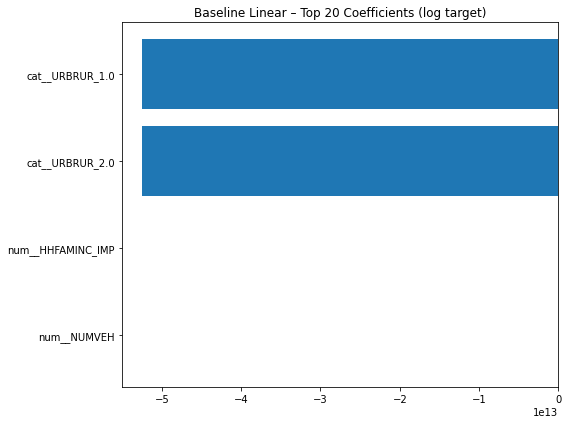

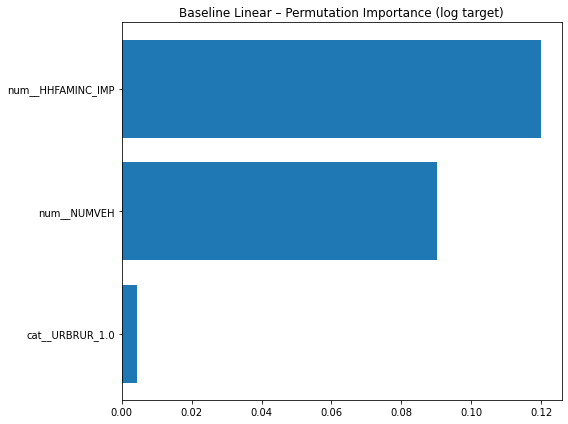

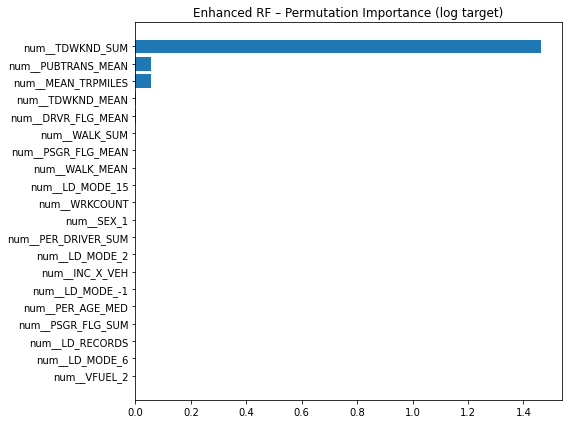

SHAP not available; skipping SHAP analysis.


In [12]:

# ==========================================
# 11) Interpretability: Coefficients & Permutation Importance (robust)
# ==========================================
from sklearn.preprocessing import OneHotEncoder

def get_pre_feature_names(pre):
    """
    Return feature names produced by a fitted ColumnTransformer.
    Prefers ColumnTransformer.get_feature_names_out(); falls back to a safe manual build.
    """
    try:
        return pre.get_feature_names_out()
    except Exception:
        names = []
        for name, trans, cols in pre.transformers_:
            if name == "remainder" and trans == "drop":
                continue
            # cols may be a string, list, or slice; normalize to list of strings
            if isinstance(cols, (list, tuple)):
                col_list = list(cols)
            else:
                col_list = [cols]
            # Resolve OneHotEncoder names
            if isinstance(trans, OneHotEncoder):
                try:
                    trans_names = list(trans.get_feature_names_out(col_list))
                except Exception:
                    trans_names = [f"{name}__{c}" for c in col_list]
            elif hasattr(trans, "get_feature_names_out"):
                try:
                    trans_names = list(trans.get_feature_names_out())
                except Exception:
                    trans_names = [f"{name}__{c}" for c in col_list]
            else:
                # For scalers or passthroughs without name method
                trans_names = [f"{name}__{c}" for c in col_list]
            names.extend(trans_names)
        return names

def align_names_and_values(names, values):
    """Ensure names and values have identical length by trimming to the min length."""
    n = min(len(names), len(values))
    return list(names)[:n], list(values)[:n]

# -------- Baseline Linear (log target) --------
pre_lin = lin_model.named_steps["pre"]
lin_names = get_pre_feature_names(pre_lin)
lin_coefs = lin_model.named_steps["reg"].coef_

lin_names_aligned, lin_coefs_aligned = align_names_and_values(lin_names, lin_coefs)

coef_df = (pd.DataFrame({"feature": lin_names_aligned, "coef": lin_coefs_aligned})
           .assign(abs_coef=lambda d: d["coef"].abs())
           .sort_values("abs_coef", ascending=False)
           .reset_index(drop=True))
coef_df.to_csv(OUT_DIR / "baseline_linear_coefficients.csv", index=False)

plt.figure(figsize=(8,6))
plt.barh(coef_df.head(20)["feature"][::-1], coef_df.head(20)["coef"][::-1])
plt.title("Baseline Linear – Top 20 Coefficients (log target)")
plt.tight_layout(); plt.savefig(FIG_DIR / "baseline_linear_top20_coefs.png", dpi=150); plt.show()

# Permutation importance (linear)
lin_perm = permutation_importance(lin_model, Xb_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
# Align feature names for permutation importance as well
lin_names_pi, lin_imp_mean = align_names_and_values(lin_names, lin_perm.importances_mean)
_, lin_imp_std = align_names_and_values(lin_names, lin_perm.importances_std)

lin_perm_df = pd.DataFrame({
    "feature": lin_names_pi,
    "import_mean": lin_imp_mean,
    "import_std": lin_imp_std
}).sort_values("import_mean", ascending=False)
lin_perm_df.to_csv(OUT_DIR / "baseline_linear_permutation_importance.csv", index=False)

plt.figure(figsize=(8,6))
plt.barh(lin_perm_df.head(20)["feature"][::-1], lin_perm_df.head(20)["import_mean"][::-1])
plt.title("Baseline Linear – Permutation Importance (log target)")
plt.tight_layout(); plt.savefig(FIG_DIR / "baseline_linear_perm_importance.png", dpi=150); plt.show()

# -------- Enhanced Random Forest (log target) --------
pre_rf = rf_model.named_steps["pre"]
rf_names = get_pre_feature_names(pre_rf)

rf_perm = permutation_importance(rf_model, Xe_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
rf_names_pi, rf_imp_mean = align_names_and_values(rf_names, rf_perm.importances_mean)
_, rf_imp_std = align_names_and_values(rf_names, rf_perm.importances_std)

rf_perm_df = pd.DataFrame({
    "feature": rf_names_pi,
    "import_mean": rf_imp_mean,
    "import_std": rf_imp_std
}).sort_values("import_mean", ascending=False)
rf_perm_df.to_csv(OUT_DIR / "enhanced_rf_permutation_importance.csv", index=False)

plt.figure(figsize=(8,6))
plt.barh(rf_perm_df.head(20)["feature"][::-1], rf_perm_df.head(20)["import_mean"][::-1])
plt.title("Enhanced RF – Permutation Importance (log target)")
plt.tight_layout(); plt.savefig(FIG_DIR / "enhanced_rf_perm_importance.png", dpi=150); plt.show()

# === SHAP Analysis (with safe import) ===
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not installed. To install, run `%pip install shap` and restart the kernel.")

RUN_SHAP = False

if SHAP_AVAILABLE and RUN_SHAP:
    try:
        # Transform features through your preprocessing step
        Xe_test_trans = rf_model.named_steps["pre"].transform(Xe_test)
        rf = rf_model.named_steps["reg"]

        # Explain
        explainer = shap.TreeExplainer(rf)
        shap_values = explainer.shap_values(Xe_test_trans)

        # Compute mean absolute SHAP per feature
        mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
        rf_names_aligned, shap_means_aligned = align_names_and_values(rf_names, mean_abs_shap)

        shap_df = (
            pd.DataFrame({"feature": rf_names_aligned, "mean_abs_shap": shap_means_aligned})
              .sort_values("mean_abs_shap", ascending=False)
              .reset_index(drop=True)
        )
        shap_df.to_csv(OUT_DIR / "enhanced_rf_shap_mean_abs.csv", index=False)

        # Plot top 20
        plt.figure(figsize=(8,6))
        plt.barh(shap_df.head(20)["feature"][::-1], shap_df.head(20)["mean_abs_shap"][::-1])
        plt.title("Enhanced RF – Mean |SHAP| (log target)")
        plt.tight_layout()
        plt.savefig(FIG_DIR / "enhanced_rf_shap_meanabs.png", dpi=150)
        plt.show()
# 
    except Exception as e:
        print("SHAP failed. Error:", e)
else:
    print("SHAP not available; skipping SHAP analysis.")

In [13]:
try:
    from xgboost import XGBRegressor
    _XGB_OK = True
except Exception:
    _XGB_OK = False
    print("xgboost not installed. To enable: pip install xgboost")

best_xgb = None
if _XGB_OK:
    pre_full = pre_enh  # Use your enhanced preprocessor

    xgb_pipe = Pipeline(steps=[
        ("pre", pre_full),
        ("reg", XGBRegressor(
            objective="reg:squarederror",
            n_estimators=200,  # ⬇ Reduced
            random_state=42,
            n_jobs=-1,
            tree_method="hist"
        ))
    ])

    # ⬇ Trimmed down parameter space
    param_dist = {
    "reg__max_depth": [3, 4, 5],
    "reg__learning_rate": [0.01, 0.03, 0.1],
    "reg__subsample": [0.6, 0.8],
    "reg__colsample_bytree": [0.6, 0.8],
    "reg__reg_lambda": [0.5, 1.0]
    }

    cv = KFold(n_splits=3, shuffle=True, random_state=42)  # ⬇ Fewer folds
    search = RandomizedSearchCV(
        estimator=xgb_pipe,
        param_distributions=param_dist,
        n_iter=10,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(Xe_train, y_train)
    best_xgb = search.best_estimator_

    print("\nBest XGB params:", search.best_params_)
    print("Best CV score (neg RMSE on log target):", search.best_score_)

    y_pred_log_xgb = best_xgb.predict(Xe_test)
    xgb_log_rmse = np.sqrt(mean_squared_error(y_test, y_pred_log_xgb))
    xgb_log_r2   = r2_score(y_test, y_pred_log_xgb)

    y_pred_xgb   = np.expm1(y_pred_log_xgb)
    y_true_xgb   = np.expm1(y_test)
    xgb_rmse     = np.sqrt(mean_squared_error(y_true_xgb, y_pred_xgb))
    xgb_mae      = mean_absolute_error(y_true_xgb, y_pred_xgb)
    xgb_rmsle    = np.sqrt(np.mean((np.log1p(y_true_xgb) - np.log1p(y_pred_xgb))**2))
    xgb_r2       = r2_score(y_true_xgb, y_pred_xgb)

    print(f"[XGB (FAST)] RMSE(log): {xgb_log_rmse:.4f}, R²(log): {xgb_log_r2:.4f} | RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, RMSLE: {xgb_rmsle:.4f}, R²: {xgb_r2:.4f}")

else:
    print("Skipping XGBoost training.")


Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best XGB params: {'reg__subsample': 0.6, 'reg__reg_lambda': 1.0, 'reg__max_depth': 3, 'reg__learning_rate': 0.1, 'reg__colsample_bytree': 0.8}
Best CV score (neg RMSE on log target): -0.06740099582113167
[XGB (FAST)] RMSE(log): 0.0674, R²(log): 0.9986 | RMSE: 112.17, MAE: 8.97, RMSLE: 0.0674, R²: 0.8241


In [14]:

# ==========================================
# 13) Exports (predictions + frontend samples)  [fixed: no .values on numpy arrays]
# ==========================================
import numpy as np
import pandas as pd

# Baseline predictions
baseline_preds = pd.DataFrame({
    "HOUSEID": np.asarray(hid_test),
    "Actual_HH_VMT": np.expm1(np.asarray(y_test)),
    "Predicted_HH_VMT": np.expm1(np.asarray(y_pred_log_lin))
})
baseline_preds.to_csv(OUT_DIR / "baseline_predictions.csv", index=False)

# Enhanced RF predictions
enhanced_preds = pd.DataFrame({
    "HOUSEID": np.asarray(hid_test),
    "Actual_HH_VMT": np.expm1(np.asarray(y_test)),
    "Predicted_HH_VMT": np.expm1(np.asarray(y_pred_log_rf))
})
enhanced_preds.to_csv(OUT_DIR / "enhanced_predictions.csv", index=False)

# XGB predictions (if available)
if 'best_xgb' in globals() and best_xgb is not None:
    xgb_preds = pd.DataFrame({
        "HOUSEID": np.asarray(hid_test),
        "Actual_HH_VMT": np.expm1(np.asarray(y_test)),
        "Predicted_HH_VMT": np.expm1(np.asarray(best_xgb.predict(Xe_test)))
    })
    xgb_preds.to_csv(OUT_DIR / "xgb_full_predictions.csv", index=False)

# Frontend samples
frontend_sample = (
    model_df.loc[Xe_test.index, ["HOUSEID","HH_VMT"] + [c for c in ["HHSIZE","WRKCOUNT","HHFAMINC_IMP","URBRUR","NUMVEH","VEH_X_WRK","HHSIZE_X_URB","INC_X_VEH"] if c in model_df.columns]]
    .assign(PRED_BASELINE=np.expm1(np.asarray(y_pred_log_lin)),
            PRED_RF=np.expm1(np.asarray(y_pred_log_rf)),
            PRED_XGB=(np.expm1(np.asarray(best_xgb.predict(Xe_test))) if 'best_xgb' in globals() and best_xgb is not None else np.nan))
    .head(100).reset_index(drop=True)
)
frontend_sample.to_csv(OUT_DIR / "frontend_sample_full.csv", index=False)

print("Files written:")
print(f"- {OUT_DIR / 'baseline_predictions.csv'}")
print(f"- {OUT_DIR / 'enhanced_predictions.csv'}")
if 'best_xgb' in globals() and best_xgb is not None:
    print(f"- {OUT_DIR / 'xgb_full_predictions.csv'}")
print(f"- {OUT_DIR / 'frontend_sample_full.csv'}")
print(f"EDA figures saved under: {FIG_DIR}")


Files written:
- outputs_full/baseline_predictions.csv
- outputs_full/enhanced_predictions.csv
- outputs_full/xgb_full_predictions.csv
- outputs_full/frontend_sample_full.csv
EDA figures saved under: outputs_full/figs


In [15]:
# === 14) Cross‐Validation & Hyperparameter Calibration ===
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error

# (Re)define the Enhanced RF pipeline, if not already in scope:
rf_pipeline = Pipeline([
    ("pre", pre_enh),
    ("reg", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
])

# 1) 5-fold CV on log-target
cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_rmse = make_scorer(lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp)), greater_is_better=True)

rmse_scores = cross_val_score(rf_pipeline, Xe_train, y_train, cv=cv, scoring=neg_rmse, n_jobs=-1)
r2_scores   = cross_val_score(rf_pipeline, Xe_train, y_train, cv=cv, scoring="r2", n_jobs=-1)

print("Enhanced RF 5-Fold CV (log1p target):")
print(f"  RMSE(log): {(-rmse_scores.mean()):.4f} ± {rmse_scores.std():.4f}")
print(f"  R²(log):   {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

# 2) Hyperparameter search for RF
param_dist = {
    "reg__n_estimators":    [200, 400, 800],
    "reg__max_depth":       [None, 10, 20, 30],
    "reg__min_samples_leaf":[1, 2, 4],
    "reg__max_features":    ["sqrt", "log2"]
}
search_rf = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring=neg_rmse,
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search_rf.fit(Xe_train, y_train)

best_rf = search_rf.best_estimator_
print("\nBest RF hyperparameters:", search_rf.best_params_)
print("Best CV RMSE(log):", -search_rf.best_score_)

# 3) Evaluate on held-out test set
y_pred_log_best = best_rf.predict(Xe_test)
rmse_log_test = np.sqrt(mean_squared_error(y_test, y_pred_log_best))
r2_log_test   = r2_score(y_test, y_pred_log_best)

y_pred_best    = np.expm1(y_pred_log_best)
y_true_orig    = np.expm1(y_test)
rmse_orig      = np.sqrt(mean_squared_error(y_true_orig, y_pred_best))
mae_orig       = mean_absolute_error(y_true_orig, y_pred_best)
rmsle_orig     = np.sqrt(np.mean((np.log1p(y_true_orig) - np.log1p(y_pred_best))**2))
r2_orig        = r2_score(y_true_orig, y_pred_best)

print(f"\nCalibrated RF on test set:")
print(f"  RMSE(log): {rmse_log_test:.4f}, R²(log): {r2_log_test:.4f}")
print(f"  RMSE(orig): {rmse_orig:.2f}, MAE: {mae_orig:.2f}, RMSLE: {rmsle_orig:.4f}, R²(orig): {r2_orig:.4f}")

Enhanced RF 5-Fold CV (log1p target):
  RMSE(log): 0.0632 ± 0.0141
  R²(log):   0.9987 ± 0.0005
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best RF hyperparameters: {'reg__n_estimators': 200, 'reg__min_samples_leaf': 1, 'reg__max_features': 'sqrt', 'reg__max_depth': 30}
Best CV RMSE(log): 0.41470421847805766

Calibrated RF on test set:
  RMSE(log): 0.4284, R²(log): 0.9430
  RMSE(orig): 246.76, MAE: 31.80, RMSLE: 0.4284, R²(orig): 0.1484


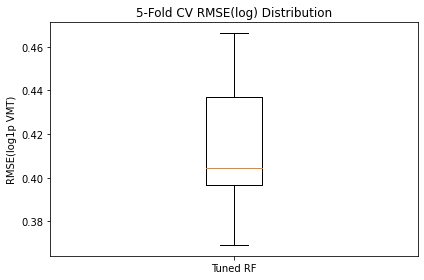

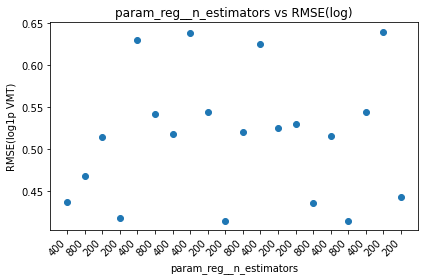

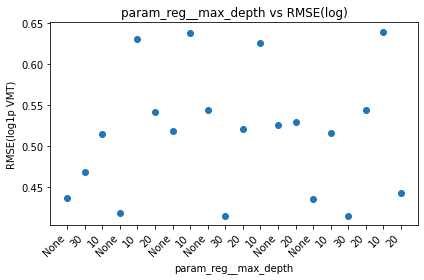

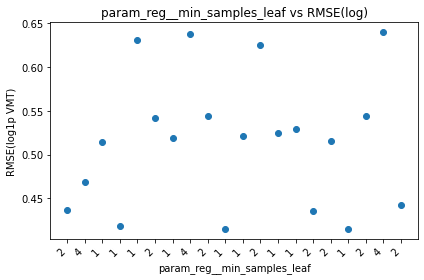

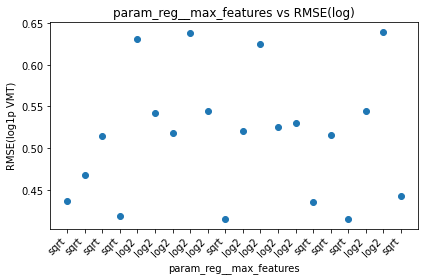

Sample True HH_VMT  : [17.23555003 55.63517713  0.         36.24860162 14.82535736]
Expected log1p       : [2.9034 4.0366 0.     3.6176 2.7616]
y_train first 5 logs: [2.9034 4.0366 0.     3.6176 2.7616]
Match?               : True


In [16]:
# ==========================================
# 16) Diagnostics: CV Boxplot, Hyperparameter Scatterplots & Target Check
# ==========================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# — 1) Boxplot of 5-fold CV RMSE(log) for the tuned RF —
model = search_rf.best_estimator_  # pipeline with preprocessor + tuned RF
cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_rmse = make_scorer(lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp)), greater_is_better=True)
rmse_scores_log = cross_val_score(model, Xe_train, y_train, cv=cv, scoring=neg_rmse, n_jobs=-1)
rmse_scores = -rmse_scores_log  # positive RMSE values

plt.figure(figsize=(6,4))
plt.boxplot(rmse_scores, labels=['Tuned RF'])
plt.ylabel('RMSE(log1p VMT)')
plt.title('5-Fold CV RMSE(log) Distribution')
plt.tight_layout()
plt.show()

# — 2) Scatterplots: hyperparameters vs CV RMSE(log) —
cv_results = pd.DataFrame(search_rf.cv_results_)
cv_results['RMSE_log'] = -cv_results['mean_test_score']

hyperparams = [
    'param_reg__n_estimators',
    'param_reg__max_depth',
    'param_reg__min_samples_leaf',
    'param_reg__max_features'
]

for p in hyperparams:
    if p in cv_results.columns:
        plt.figure(figsize=(6,4))
        if cv_results[p].dtype == object:
            xs = np.arange(len(cv_results))
            plt.scatter(xs, cv_results['RMSE_log'])
            plt.xticks(xs, cv_results[p].astype(str), rotation=45, ha='right')
            plt.xlabel(p)
        else:
            plt.scatter(cv_results[p], cv_results['RMSE_log'])
            plt.xlabel(p)
        plt.ylabel('RMSE(log1p VMT)')
        plt.title(f'{p} vs RMSE(log)')
        plt.tight_layout()
        plt.show()

# — 3) Quick target transformation check —
if 'HH_VMT' in hh.columns:
    idx = Xe_train.index[:5]
    true_vals = hh.loc[idx, 'HH_VMT'].to_numpy()
    logged_true = np.log1p(true_vals)
    print("Sample True HH_VMT  :", true_vals)
    print("Expected log1p       :", np.round(logged_true,4))
    print("y_train first 5 logs:", np.round(y_train.iloc[:5].to_numpy(),4))
    print("Match?               :", np.allclose(y_train.iloc[:5].to_numpy(), logged_true))
else:
    print("HH_VMT column not found for target check.")


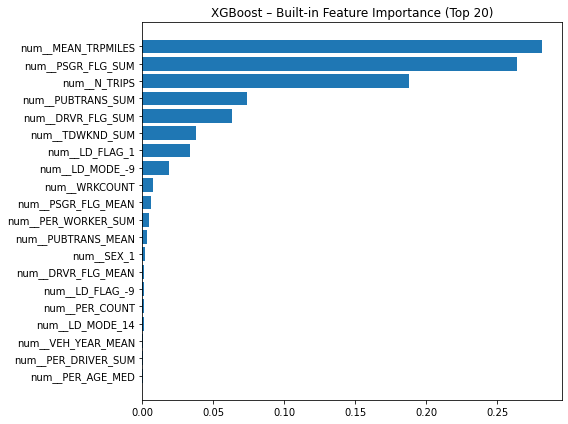

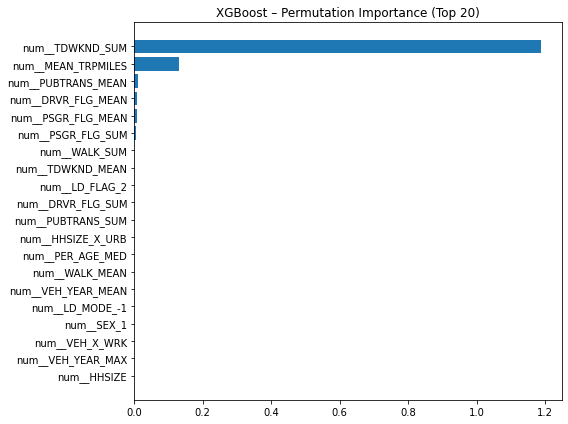

In [17]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get the fitted regressor and preprocessing pipeline
xgb_model = best_xgb.named_steps["reg"]
xgb_pre = best_xgb.named_steps["pre"]

# Get transformed feature names
def get_feature_names(pre):
    try:
        return pre.get_feature_names_out()
    except:
        # Fallback if sklearn version is older
        names = []
        for name, trans, cols in pre.transformers_:
            if isinstance(cols, str):
                cols = [cols]
            elif isinstance(cols, slice):
                cols = list(pre._feature_names_in[cols])
            if hasattr(trans, "get_feature_names_out"):
                names.extend(trans.get_feature_names_out(cols))
            else:
                names.extend([f"{name}__{col}" for col in cols])
        return names

feature_names = get_feature_names(xgb_pre)

# --------------------------
# 1. XGBoost built-in importance
# --------------------------
xgb_fi = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=False)

# Save & Plot
xgb_fi.to_csv(OUT_DIR / "xgb_builtin_importance.csv", index=False)

plt.figure(figsize=(8,6))
plt.barh(xgb_fi.head(20)["feature"][::-1], xgb_fi.head(20)["importance"][::-1])
plt.title("XGBoost – Built-in Feature Importance (Top 20)")
plt.tight_layout()
plt.savefig(FIG_DIR / "xgb_builtin_importance_top20.png", dpi=150)
plt.show()

# --------------------------
# 2. Permutation importance
# --------------------------
perm = permutation_importance(best_xgb, Xe_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

perm_fi = pd.DataFrame({
    "feature": feature_names[:len(perm.importances_mean)],
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

# Save & Plot
perm_fi.to_csv(OUT_DIR / "xgb_permutation_importance.csv", index=False)

plt.figure(figsize=(8,6))
plt.barh(perm_fi.head(20)["feature"][::-1], perm_fi.head(20)["importance_mean"][::-1])
plt.title("XGBoost – Permutation Importance (Top 20)")
plt.tight_layout()
plt.savefig(FIG_DIR / "xgb_perm_importance_top20.png", dpi=150)
plt.show()
